# Decomposition using ROHSA

Gaussian decompostion of the HI data cube using ROHSA

# Libraries

In [1]:
#!/usr/bin/env python

"""

"""

from __future__ import print_function

__authors__ = 'Van Hiep NGUYEN <vanhiep.nguyen@anu.edu.au>'
__version__ = '2023/01/01'                                                                                                                          
import os
import warnings
import time
import copy

# Ignore these warnings, it's a bug
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
import seaborn as sns
import numpy   as np
import pandas  as pd

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [3]:
import astropy
import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file
from astropy.io.votable import from_table, parse_single_table, parse
from astropy.coordinates import SkyCoord

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy import constants as const

from spectral_cube import SpectralCube
from astropy.wcs import WCS

import math

In [4]:
from plotbin.symmetrize_velfield import symmetrize_velfield
from plotbin.plot_velfield import plot_velfield

import marchalib as ml
from ROHSApy import ROHSA

# Paths

In [5]:
base  = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC   = os.path.join(askap, 'LMC')

LMC_plots = os.path.join(LMC, 'plots')
MW_em_abs_plots = os.path.join(LMC_plots, 'em_abs_mw' )


data_path = os.path.join(askap, 'data')

LMC_data_path   = os.path.join(data_path, 'LMC')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')

LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
GASS_data_path = os.path.join(LMC_data_path, 'GASS')
GASS_subcube_dir = os.path.join(GASS_data_path, "subcubes")
neighbour_emission_spectra_path = os.path.join(LMC_data_path, 'neighbour_emission_spectra')
print(f"GASS subcube path for each source: {GASS_subcube_dir}")
print(f"GASS neighbour emission spectra path: {neighbour_emission_spectra_path}")


SMC = os.path.join(askap, 'SMC')
SMC_data_path = os.path.join(data_path, 'SMC')
SMC_fg_data_path = os.path.join(SMC_data_path, 'fg')
SMC_fg_abs_data_path = os.path.join(SMC_fg_data_path, 'spectra')
SMC_plots = os.path.join(SMC, 'plots')
SMC_fg_em_abs_plots = os.path.join(SMC_plots, 'em_abs_mw' )

GASS_SMC_data_path = os.path.join(SMC_data_path, 'GASS')
SMC_neighbour_em_spec_path = os.path.join(SMC_data_path, 'em_spectra')
GASS_SMC_subcube_dir = os.path.join(GASS_SMC_data_path, "subcubes")


ROHSA_data_path = os.path.join(data_path, 'ROHSA')
ROHSA_GASS_data_path = os.path.join(ROHSA_data_path, 'GASS')

ROHSA_radifs_data_path = os.path.join(ROHSA_data_path, 'radifs')
ROHSA_radifs_data_path

GASS subcube path for each source: /Users/kiemhiep/ANU/ASKAP/data/LMC/GASS/subcubes
GASS neighbour emission spectra path: /Users/kiemhiep/ANU/ASKAP/data/LMC/neighbour_emission_spectra


'/Users/kiemhiep/ANU/ASKAP/data/ROHSA/radifs'

# Fcn

In [6]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    return tuple(i/inch for i in tupl)

In [7]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    # dat, hdr = fits.getdata(filename, header=True)
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    
    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    w = WCS(hdr)


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)
    
    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity
    
    return c, w, x, y, v, hdr

In [8]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()


def get_source_infor(df, field_id, source):
    src_info = df.loc[(df["comp_name"] == source) & (df["sbid"] == field_id)]
    nfound = len(src_info['comp_name'].unique())
    
    if nfound == 0:
        print("Error: No source found!")
        return None

    if nfound == 1:
        return src_info.iloc[0]
    else:
        print("Error: source is not unique!")
        return None


def get_source_info_from_name(df, source):
    src_info = df.loc[df["comp_name"] == source]
    nfound = len(src_info['comp_name'].unique())
    
    if nfound == 0:
        print("Error: No source found!")
        return None
    
    return src_info.iloc[0]


def radec2lb(ra, dec):
    """
    Convert RADEC to Galactic Coordinates (l,b)
    
    Inputs:
    RA in degrees (0, 360)
    DEC in degrees (-90, 90)
    
    Outputs:
    Galactic longitude in degrees (0, 360)
    Galactic latitude in degrees (-90, 90)
    """
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    gl = np.array(c.galactic.l)
    gb = np.array(c.galactic.b)
    
    return gl, gb

In [9]:
def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

# Read data

In [10]:
# LMC fg datacube
filename = "LVHIS053.na.icln.K.fits"
datacube_file = os.path.join(ROHSA_radifs_data_path, 'data', filename)
datacube_file

'/Users/kiemhiep/ANU/ASKAP/data/ROHSA/radifs/data/LVHIS053.na.icln.K.fits'

In [11]:
rcube, cube_wcs, cube_ra, cube_dec, cube_vlsr, hdr = read_fits_cube(datacube_file)
print(cube_wcs)
print(rcube)

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/io/core.py:184: StokesWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "

Cube shape: (110, 616, 617)
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'VOPT'  'STOKES'  
CRVAL : 204.253333342  -29.8830555555  280000.0  1.0  
CRPIX : 309.0  309.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00277777798786  0.00277777798786  4000.0  1.0  
NAXIS : 617  616  110
SpectralCube with shape=(110, 616, 617) and unit=K:
 n_x:    617  type_x: RA---SIN  unit_x: deg    range:   203.258143 deg:  205.248523 deg
 n_y:    616  type_y: DEC--SIN  unit_y: deg    range:   -30.713260 deg:  -29.003844 deg
 n_s:    110  type_s: VOPT      unit_s: m / s  range:   280000.000 m / s:  7

In [12]:
# w = ml.wcs2D(hdr)
cube_wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'VOPT'  'STOKES'  
CRVAL : 204.253333342  -29.8830555555  280000.0  1.0  
CRPIX : 309.0  309.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.00277777798786  0.00277777798786  4000.0  1.0  
NAXIS : 617  616  110

In [13]:
# for x in hdr:
#     print(x, hdr[x])

In [14]:
m0 = rcube.with_spectral_unit(u.km/u.s, velocity_convention='radio').moment(order=0)  # Zero-th moment
print(m0.shape)
print(m0.wcs)

(616, 617)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 204.253333342  -29.8830555555  
CRPIX : 309.0  309.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00277777798786  0.00277777798786  
NAXIS : 0  0


In [67]:
cube = np.array(rcube)
nchan, ylen, xlen = cube.shape
print(nchan, ylen, xlen)

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/wcs_utils.py:430: WCSWarning: WCS1 is missing card PV2_1
  warnings.warn("WCS1 is missing card {0}".format(key), WCSWarning)

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/wcs_utils.py:430: WCSWarning: WCS1 is missing card PV2_2
  warnings.warn("WCS1 is missing card {0}".format(key), WCSWarning)

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/wcs_utils.py:430: WCSWarning: WCS1 is missing card PV2_1
  warnings.warn("WCS1 is missing card {0}".format(key), WCSWarning)

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/wcs_utils.py:430: WCSWarning: WCS1 is missing card PV2_2
  warnings.warn("WCS1 is missing card {0}".format(key), WCSWarning)

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/wcs_utils.py:430: WCSWarning: WCS1 is missing card PV2_1
  warnings.warn("WCS1 is

In [16]:
rms = np.std(cube[:15],0)
rms.shape

(616, 617)

In [17]:
vlsr = np.array(cube_vlsr)/1000. # km/s
dv = np.diff(vlsr)[0]
dv

4.0

In [18]:
# WHI = np.sum(cube, axis=0)
NHI_thin = 1.8224e-2 * np.array(m0)

In [19]:
# NHI_thin = 1.8224e-2 * np.sum(cube, axis=0) * dv # in 10^20
# NHI_thin[NHI_thin < 0.] = 0

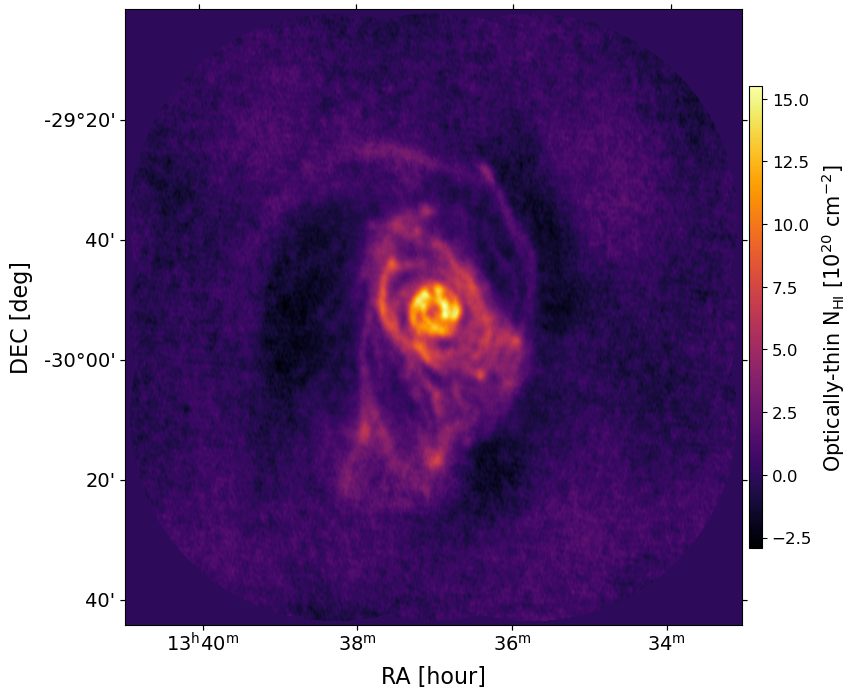

In [75]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=m0.wcs)

# map
im = ax.imshow(NHI_thin, cmap='inferno') # viridis, cividis, inferno, plasma, magma

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=12)


# Add axes labels
ax.set_title('')
ax.set_xlabel("RA [hour]", fontsize=16)
ax.set_ylabel("DEC [deg]", fontsize=16)
ax.tick_params(labelsize=14)

plt.show()

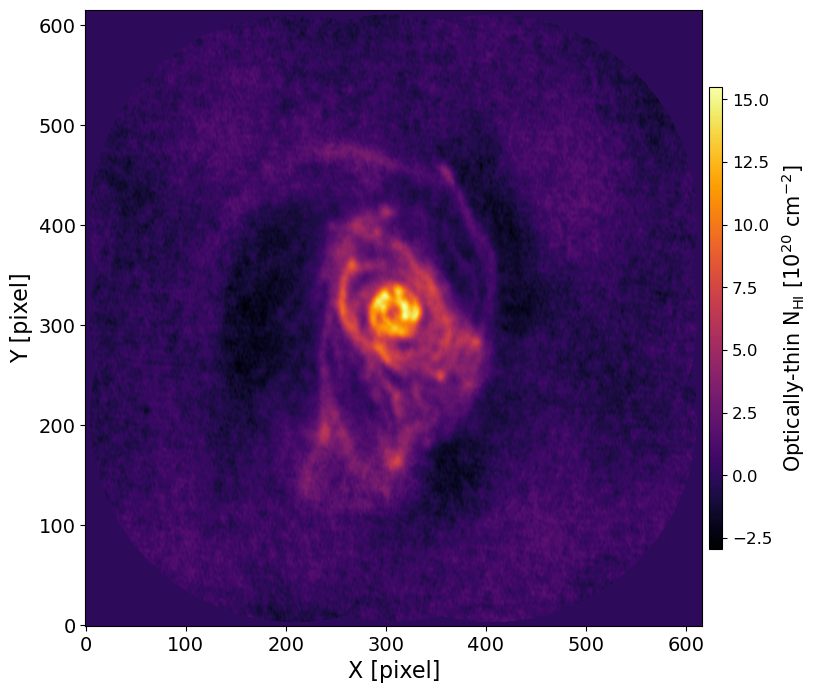

In [21]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# map
im = ax.imshow(NHI_thin, origin='lower', cmap='inferno') # viridis, cividis, inferno, plasma, magma

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel('Optically-thin N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=12)


# Add axes labels
ax.set_title('')
ax.set_xlabel("X [pixel]", fontsize=16)
ax.set_ylabel("Y [pixel]", fontsize=16)
ax.tick_params(labelsize=14)

plt.show()

# Plot some spectra

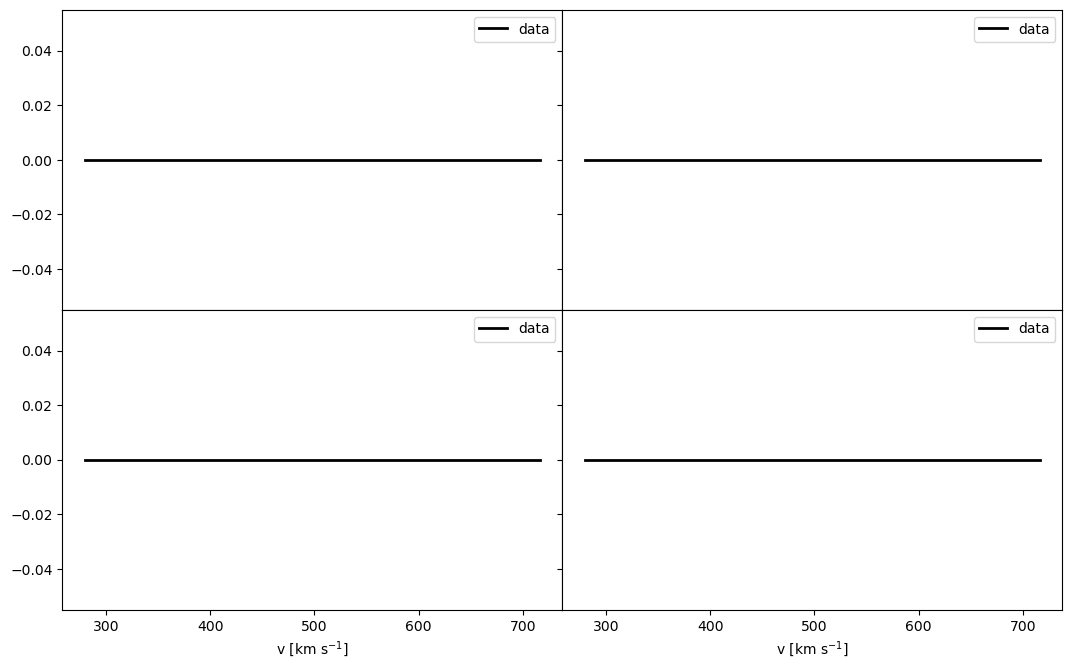

In [70]:
# Plot spectra
ny = 2
nx = 2                                                                                                                                          
center_y = 10
center_x = 10

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        ax = axs[i,j]
        ax.plot(vlsr, cube[:, center_y+j, center_x+i],
                color='k',
                linewidth=2.,
                label='data'
        )

        ax.legend(loc = 'upper right')
        ax.set_xlabel(r'v [km s$^{-1}$]')

plt.show()

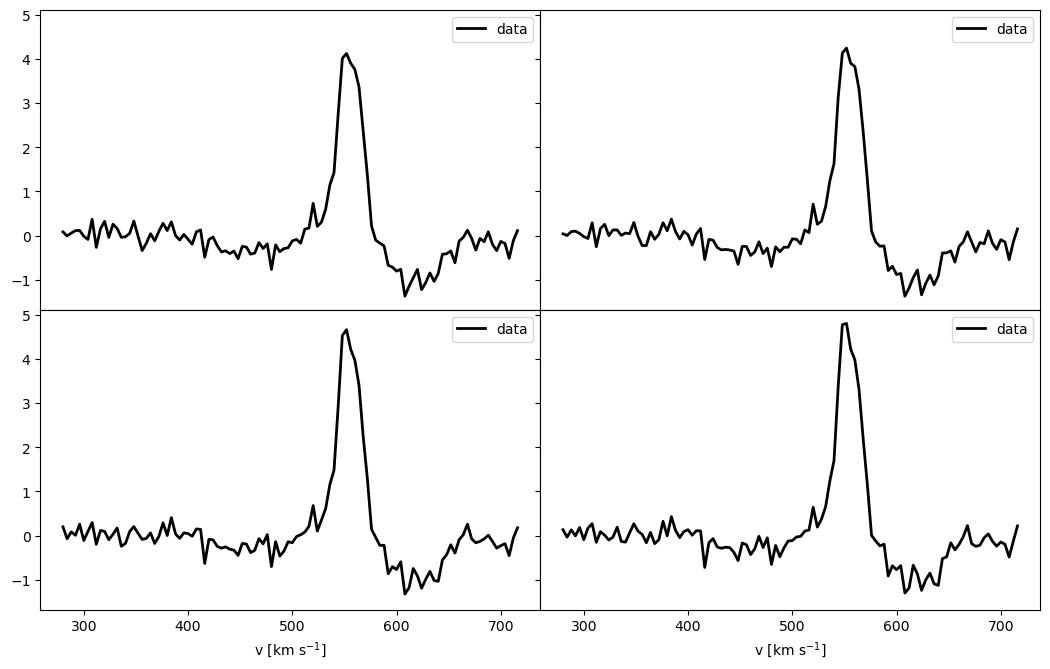

In [69]:
# Plot spectra
ny = 2
nx = 2                                                                                                                                          
center_y = 250
center_x = 250

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        ax = axs[i,j]
        ax.plot(vlsr, cube[:, center_y+j, center_x+i],
                color='k',
                linewidth=2.,
                label='data'
        )

        ax.legend(loc = 'upper right')
        ax.set_xlabel(r'v [km s$^{-1}$]')

plt.show()

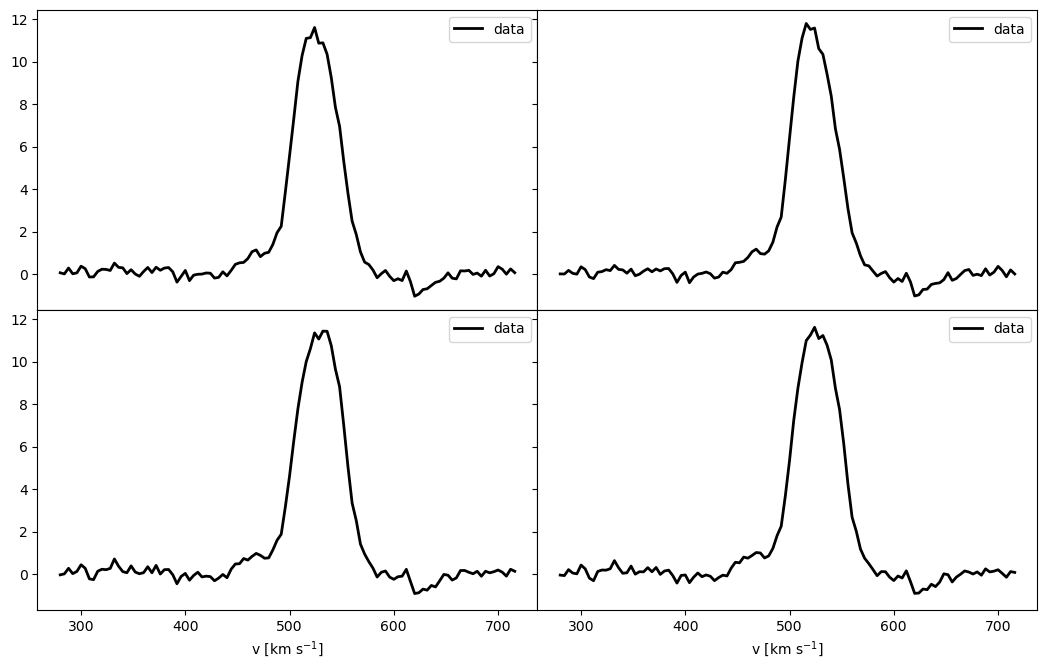

In [68]:
# Plot spectra
ny = 2
nx = 2                                                                                                                                          
center_y = 300
center_x = 300

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        ax = axs[i,j]
        ax.plot(vlsr, cube[:, center_y+j, center_x+i],
                color='k',
                linewidth=2.,
                label='data'
        )

        ax.legend(loc = 'upper right')
        ax.set_xlabel(r'v [km s$^{-1}$]')

plt.show()

# Read results from ROHSA Gaussian decomposition

In [25]:
core = ROHSA(cube, hdr=hdr)
core

In [26]:
# Read results of ROHSA decomposition
output_filename = "M83_cube_gauss_run_0.fits"
output_file = os.path.join(ROHSA_radifs_data_path, 'ROHSA', output_filename)
output_file

'/Users/kiemhiep/ANU/ASKAP/data/ROHSA/radifs/ROHSA/M83_cube_gauss_run_0.fits'

In [27]:
output, hdr = fits.getdata(output_file, header=True)
output.shape

(12, 616, 617)

In [28]:
params = core.physical_gaussian(output)
model = core.return_result_cube(output)

In [79]:
model.shape

(110, 616, 617)

In [85]:
nparams, _, _ = params.shape
n_gauss = nparams // 3
print('N params = ', nparams)
print('N Gaussians = ', n_gauss)
print('N x-pixels = ', xlen)
print('N y-pixels = ', ylen)

N params =  12
N Gaussians =  4
N x-pixels =  617
N y-pixels =  616


In [86]:
ampfield = params[0::3]
vfield = params[1::3]
sigfield = np.abs(params[2::3])

field =  ampfield * sigfield * np.sqrt(2.*np.pi) * 1.82243e-2 # 10^20 cm^-2

ampfield_pix = output[0::3]
vfield_pix = output[1::3]
sigfield_pix = output[2::3]

In [87]:
# Amplitude of Gaussians in the datacube
ampfield_pix.shape

(4, 616, 617)

In [88]:
iddx = np.argsort(np.mean(vfield, axis=(1,2)))
iddx.shape

(4,)

In [89]:
field = [field[idd] for idd in iddx]
vfield = [vfield[idd] for idd in iddx]
ampfield = [ampfield[idd] for idd in iddx]
sigfield = [sigfield[idd] for idd in iddx]

vfield_pix = [vfield_pix[idd] for idd in iddx]
ampfield_pix = [ampfield_pix[idd] for idd in iddx]
sigfield_pix = [sigfield_pix[idd] for idd in iddx]

# Plot model of the integrated column density map

In [90]:
NHI_thin_model = 1.8224e-2 * np.sum(model, axis=0) * dv # in 10^20

In [91]:
# diff = 100.* np.abs(NHI_thin_model - NHI_thin) / NHI_thin
diff = np.abs(NHI_thin_model - NHI_thin)

In [92]:
print(diff.min(), diff.max())

0.0 3.0523208426695856


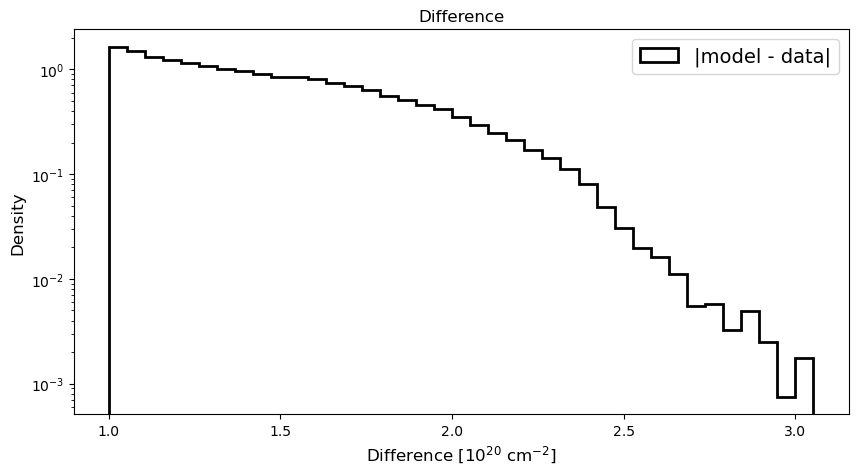

In [94]:
# Plot histograms
diff_flattened = diff.flatten()
plt.figure(figsize=(10, 5))

plt.hist(diff_flattened,
         bins=np.linspace(1., diff_flattened.max(), 40),
         density=True, color='k', histtype='step',
         alpha=1., ls='-', lw=2,
         label='|model - data|')

plt.title('Difference')
plt.xlabel(r'Difference [10$^{20}$ cm$^{-2}$]', fontsize=12)
plt.ylabel(r'Density', fontsize=12)
plt.yscale('log')

plt.legend(loc='upper right', fontsize=14)
plt.show()

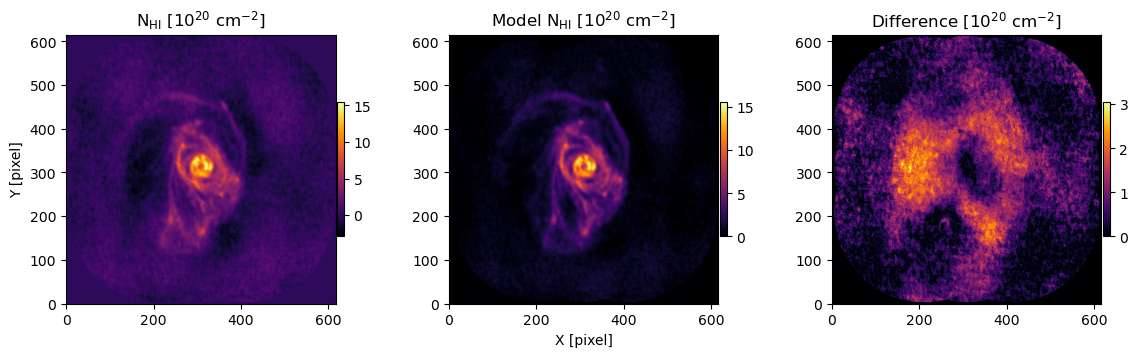

In [95]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(NHI_thin, origin="lower", cmap="inferno")
plt.colorbar(shrink=0.25, pad=0.005)
plt.title(r'N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]')
plt.ylabel('Y [pixel]')

plt.subplot(1,3,2)
plt.imshow(NHI_thin_model, origin="lower", cmap="inferno")
plt.colorbar(shrink=0.25, pad=0.005)
plt.title(r'Model N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]')
plt.xlabel('X [pixel]')

plt.subplot(1,3,3)
plt.imshow(diff, origin="lower", cmap="inferno")
plt.colorbar(shrink=0.25, pad=0.005)
plt.title(r'Difference [10$^{20}$ cm$^{-2}$]')

plt.show()

# Chi2 map

In [96]:
mean_sig = np.array([np.around(np.mean(sigfields), decimals=1) for sigfields in sigfield])
mean_v = np.array([np.around(np.mean(vfields), decimals=1) for vfields in vfield])

In [97]:
np.array(field).shape

(4, 616, 617)

In [98]:
# Chi2
n_gauss = len(field)

p = 0.05
fg = [f/np.sum(field,0) for f in field]
Ng = np.zeros((n_gauss, ylen, xlen)) 
for i in np.arange(n_gauss):
    Ng[i][np.where(fg[i] > p)] = 1 

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_26254/1913038774.py:5: RuntimeWarning: invalid value encountered in divide
  fg = [f/np.sum(field,0) for f in field]



In [99]:
dim_cube = nchan * ylen * xlen
dim_params = (3*n_gauss * ylen * xlen)

In [100]:
chi2_map = np.nansum((model - cube)**2 / rms**2, axis=0)
rchi2_map = chi2_map / (nchan - 3*n_gauss)
rchi2_map_u = chi2_map / (nchan - 3*np.sum(Ng,0))
chi2 = np.sum(chi2_map)
rchi2 = chi2 / (dim_cube - dim_params)
rchi2_u = chi2 / (dim_cube - 3*np.sum(Ng))

chi2_cont_mean = np.nanmean((model - cube)**2 / rms**2, axis=(1,2))
chi2_cont = (model - cube)**2 / rms**2

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_26254/4118896354.py:1: RuntimeWarning: invalid value encountered in divide
  chi2_map = np.nansum((model - cube)**2 / rms**2, axis=0)

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_26254/4118896354.py:8: RuntimeWarning: invalid value encountered in divide
  chi2_cont_mean = np.nanmean((model - cube)**2 / rms**2, axis=(1,2))

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_26254/4118896354.py:9: RuntimeWarning: invalid value encountered in divide
  chi2_cont = (model - cube)**2 / rms**2



X2 min, max:  0.0 42.75327333015336


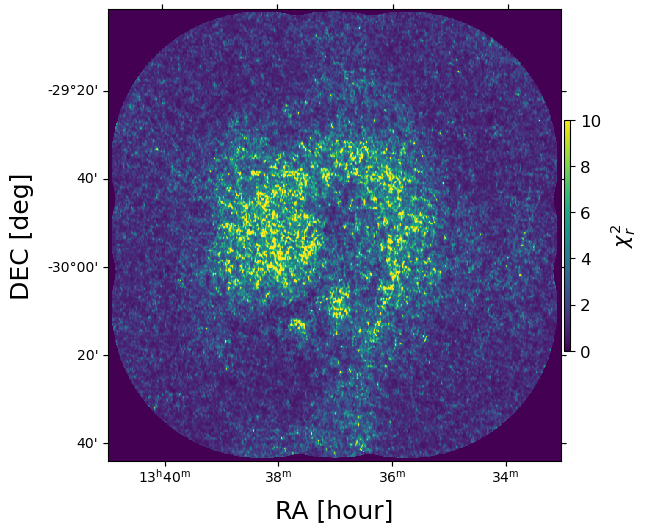

In [105]:
print('X2 min, max: ', rchi2_map.min(), rchi2_map.max())

#Reduced chi2 map
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=m0.wcs)


imkw_inf = dict(origin='lower', interpolation='none', cmap='viridis')
im = ax.imshow(rchi2_map, vmax=10., **imkw_inf)

cm_inf = plt.get_cmap().copy()
cm_inf.set_bad(color='white')
cm_inf.set_under(color='black')

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel(r"$\chi^2_r$", rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=12)

ax.set_xlabel(r"RA [hour]", fontsize=18.)
ax.set_ylabel(r"DEC [deg]", fontsize=18.)

# plt.savefig('', format='png', bbox_inches='tight', pad_inches=0.02)
plt.show()

In [106]:
# HEATMAP
hgts = params[0::3].ravel()
cens = params[1::3].ravel()
sigs = params[2::3].ravel()

x_bins = np.linspace(np.min(cens), np.max(cens), 800)
y_bins = np.linspace(np.min(sigs), np.max(sigs), 800)

H, xedges, yedges = np.histogram2d(
    cens, sigs,
    weights =np.sqrt(2.*np.pi)*hgts*sigs*1.82243e18/1.e18/np.sum(field),
    bins=[x_bins, y_bins]
)

H = np.ma.masked_invalid(np.atleast_2d(H))

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_26254/1275236790.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap='inferno')



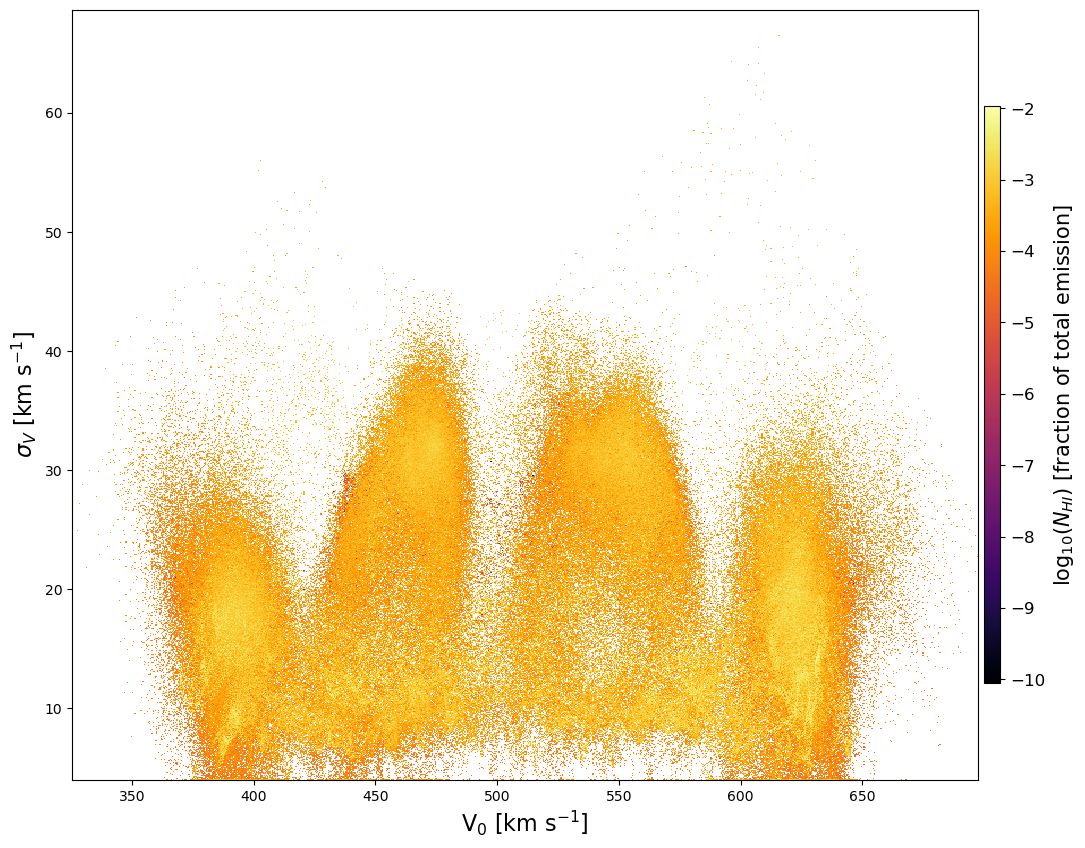

In [108]:
fig = plt.figure(figsize=(12.,10.))
ax = fig.add_subplot(111)

im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap='inferno')

cm_inf = plt.get_cmap().copy()
cm_inf.set_bad(color='white', alpha=0.2)
# cm_inf.set_under(color='black')


ax.set_xlim([np.min(cens), np.max(cens)])
ax.set_xlabel(r'V$_0$ [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma_{V}$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel(r'log$_{10}$($N_{HI}$) [fraction of total emission]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=12)

# plt.savefig('.png', format='png', bbox_inches='tight', pad_inches=0.02)
plt.show()

# Plot spectra and fitted model

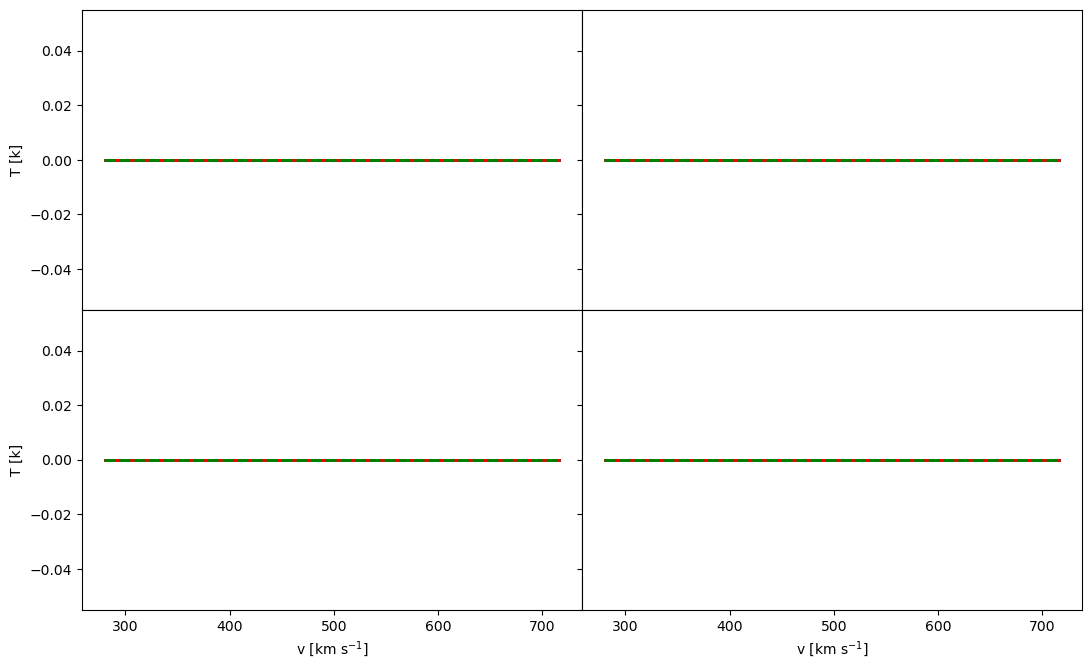

In [118]:
# Plot mosaic spectra                                                             
pvalues = np.logspace(-1, 0, 18)
pmin = pvalues[0]
pmax = pvalues[-1]

ny = 2
nx = 2                                                                                                                                          
center_y = 10
center_x = 10

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        axs[i][j].step(
            core.v,
            cube[:, center_y+j, center_x+i],
            color = 'k',
            linewidth = 2.
        )
        
        axs[i][j].plot(
            core.v,
            model[:, center_y+j, center_x+i],
            linestyle = "-",
            linewidth = 2.,
            color = "r"
        )
        
        for k in range(n_gauss):            
            axs[i][j].plot(
                core.v,
                core.gauss(np.arange(len(core.v)),
                           ampfield_pix[k][center_y+i,center_x+j], 
                           vfield_pix[k][center_y+i,center_x+j],
                           sigfield_pix[k][center_y+i,center_x+j]),
                linewidth = 2.,
                ls = '--',
                # color=plt.cm.inferno(pvalues[k])
                color = 'g'
            )
            
        if j == 0:
            axs[i][j].set_ylabel(r'T [k]')

        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# Endfor

# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

plt.show()


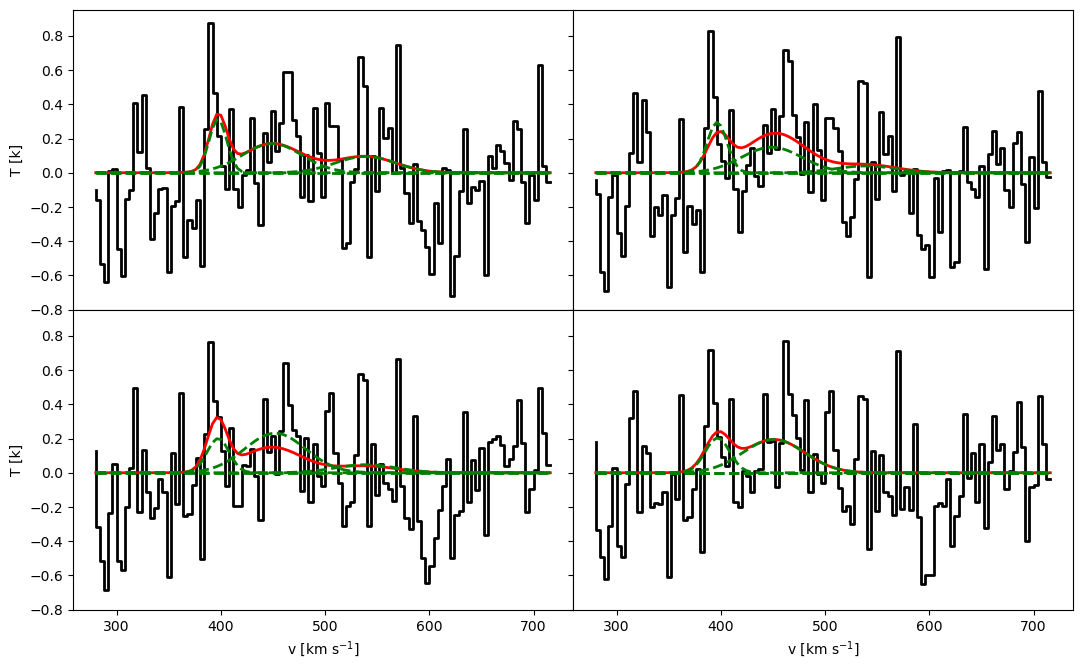

In [119]:
# Plot mosaic spectra                                                             
pvalues = np.logspace(-1, 0, 18)
pmin = pvalues[0]
pmax = pvalues[-1]

ny = 2
nx = 2                                                                                                                                          
center_y = 128
center_x = 128

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        axs[i][j].step(
            core.v,
            cube[:, center_y+j, center_x+i],
            color = 'k',
            linewidth = 2.
        )
        
        axs[i][j].plot(
            core.v,
            model[:, center_y+j, center_x+i],
            linestyle = "-",
            linewidth = 2.,
            color = "r"
        )
        
        for k in range(n_gauss):            
            axs[i][j].plot(
                core.v,
                core.gauss(np.arange(len(core.v)),
                           ampfield_pix[k][center_y+i,center_x+j], 
                           vfield_pix[k][center_y+i,center_x+j],
                           sigfield_pix[k][center_y+i,center_x+j]),
                linewidth = 2.,
                ls = '--',
                # color=plt.cm.inferno(pvalues[k])
                color = 'g'
            )
            
        if j == 0:
            axs[i][j].set_ylabel(r'T [k]')

        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# Endfor

# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

plt.show()


In [112]:
np.std(cube[:, 128, 128])

0.3236852

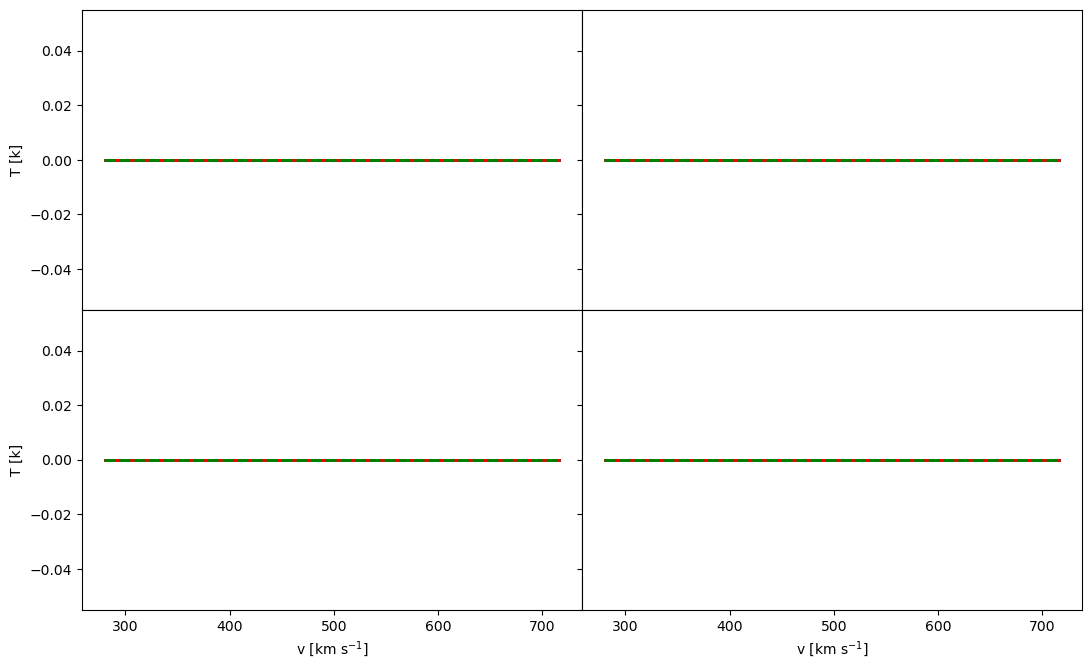

In [120]:
# Plot mosaic spectra                                                             
pvalues = np.logspace(-1, 0, 18)
pmin = pvalues[0]
pmax = pvalues[-1]

ny = 2
nx = 2                                                                                                                                          
center_y = 20
center_x = 20

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        axs[i][j].step(
            core.v,
            cube[:, center_y+j, center_x+i],
            color = 'k',
            linewidth = 2.
        )
        
        axs[i][j].plot(
            core.v,
            model[:, center_y+j, center_x+i],
            linestyle = "-",
            linewidth = 2.,
            color = "r"
        )
        
        for k in range(n_gauss):            
            axs[i][j].plot(
                core.v,
                core.gauss(np.arange(len(core.v)),
                           ampfield_pix[k][center_y+i,center_x+j], 
                           vfield_pix[k][center_y+i,center_x+j],
                           sigfield_pix[k][center_y+i,center_x+j]),
                linewidth = 2.,
                ls = '--',
                # color=plt.cm.inferno(pvalues[k])
                color = 'g'
            )
            
        if j == 0:
            axs[i][j].set_ylabel(r'T [k]')

        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# Endfor

# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

plt.show()


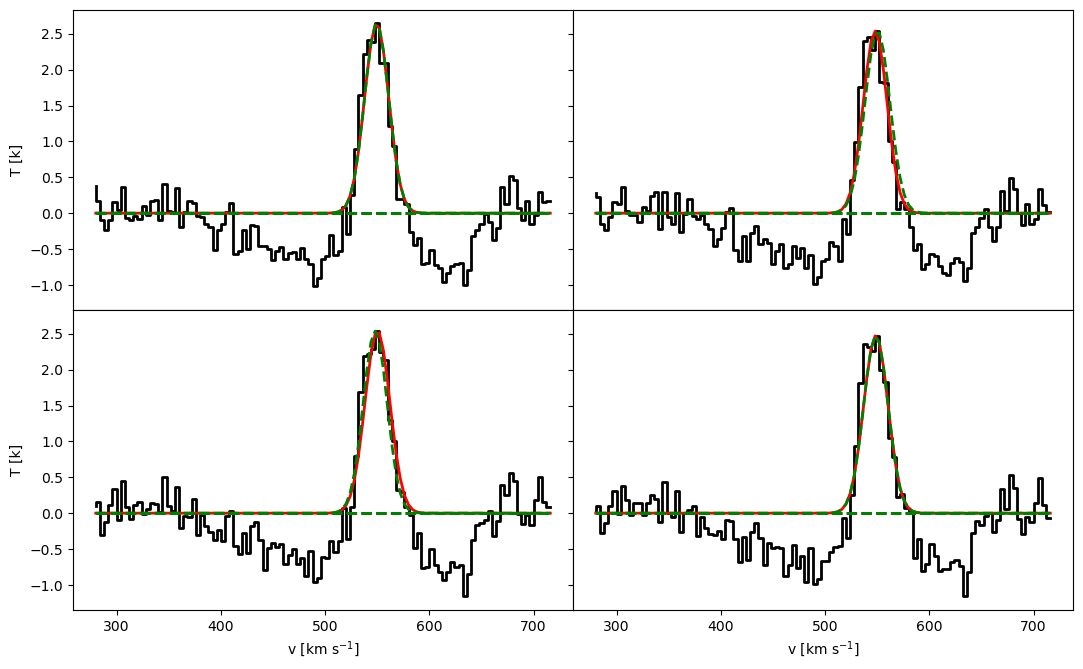

In [121]:
# Plot mosaic spectra                                                             
pvalues = np.logspace(-1, 0, 18)
pmin = pvalues[0]
pmax = pvalues[-1]

ny = 2
nx = 2                                                                                                                                          
center_y = 250
center_x = 200

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        axs[i][j].step(
            core.v,
            cube[:, center_y+j, center_x+i],
            color = 'k',
            linewidth = 2.
        )
        
        axs[i][j].plot(
            core.v,
            model[:, center_y+j, center_x+i],
            linestyle = "-",
            linewidth = 2.,
            color = "r"
        )
        
        for k in range(n_gauss):            
            axs[i][j].plot(
                core.v,
                core.gauss(np.arange(len(core.v)),
                           ampfield_pix[k][center_y+i,center_x+j], 
                           vfield_pix[k][center_y+i,center_x+j],
                           sigfield_pix[k][center_y+i,center_x+j]),
                linewidth = 2.,
                ls = '--',
                # color=plt.cm.inferno(pvalues[k])
                color = 'g'
            )
            
        if j == 0:
            axs[i][j].set_ylabel(r'T [k]')

        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# Endfor

# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

plt.show()


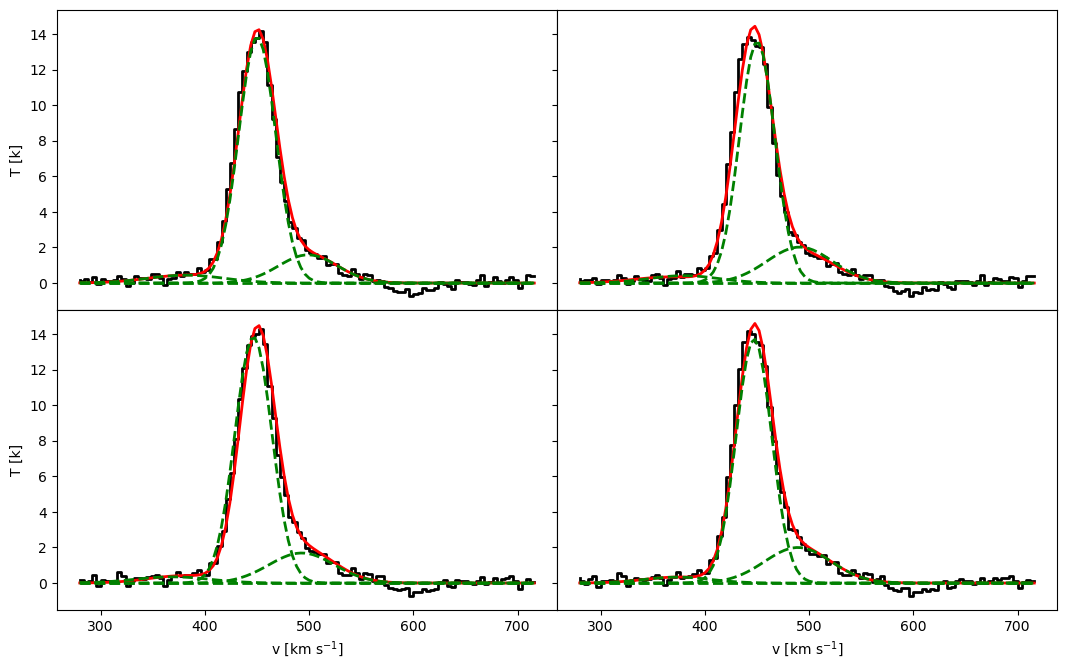

In [122]:
# Plot mosaic spectra                                                             
pvalues = np.logspace(-1, 0, 18)
pmin = pvalues[0]
pmax = pvalues[-1]
                                                         
ny = 2
nx = 2                                                                                                                                          
center_y = 320
center_x = 295

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        axs[i][j].step(
            core.v,
            cube[:, center_y+j, center_x+i],
            color = 'k',
            linewidth = 2.
        )
        
        axs[i][j].plot(
            core.v,
            model[:, center_y+j, center_x+i],
            linestyle = "-",
            linewidth = 2.,
            color = "r"
        )
        
        for k in range(n_gauss):            
            axs[i][j].plot(
                core.v,
                core.gauss(np.arange(len(core.v)),
                           ampfield_pix[k][center_y+i,center_x+j], 
                           vfield_pix[k][center_y+i,center_x+j],
                           sigfield_pix[k][center_y+i,center_x+j]),
                linewidth = 2.,
                ls = '--',
                # color=plt.cm.inferno(pvalues[k])
                color = 'g'
            )
            
        if j == 0:
            axs[i][j].set_ylabel(r'T [k]')

        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# Endfor

# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

plt.show()


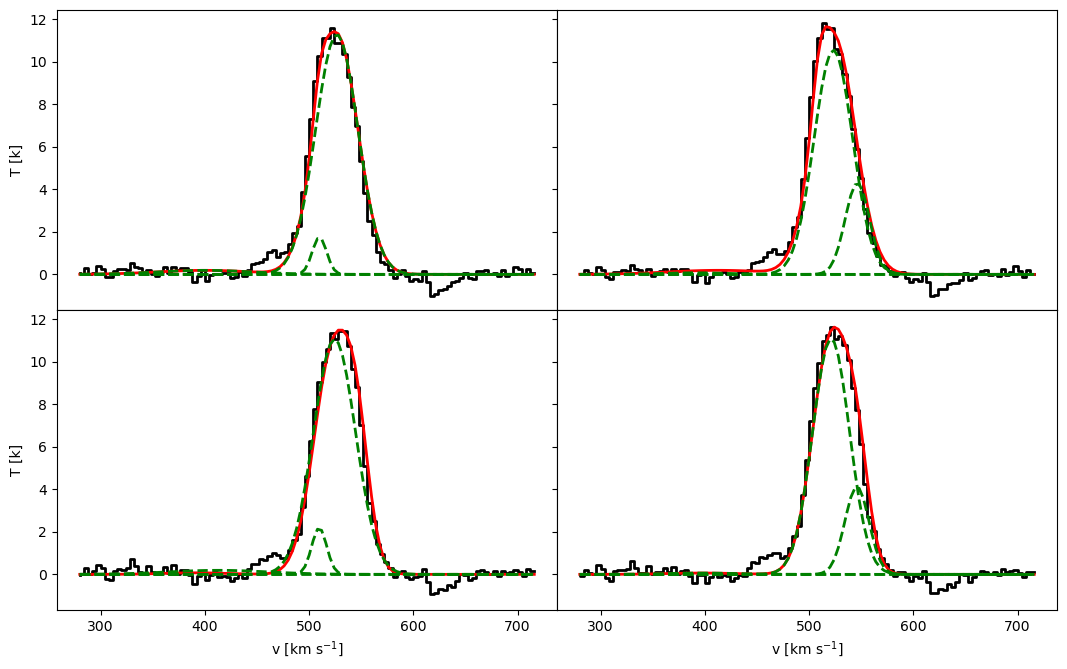

In [123]:
# Plot mosaic spectra                                                             
pvalues = np.logspace(-1, 0, 18)
pmin = pvalues[0]
pmax = pvalues[-1]
                                                         
ny = 2
nx = 2                                                                                                                                          
center_y = 300
center_x = 300

cb = "magenta"
cw = "crimson"

# Plot
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)

for i in np.arange(nx):
    for j in np.arange(ny):
        axs[i][j].step(
            core.v,
            cube[:, center_y+j, center_x+i],
            color = 'k',
            linewidth = 2.
        )
        
        axs[i][j].plot(
            core.v,
            model[:, center_y+j, center_x+i],
            linestyle = "-",
            linewidth = 2.,
            color = "r"
        )
        
        for k in range(n_gauss):            
            axs[i][j].plot(
                core.v,
                core.gauss(np.arange(len(core.v)),
                           ampfield_pix[k][center_y+i,center_x+j], 
                           vfield_pix[k][center_y+i,center_x+j],
                           sigfield_pix[k][center_y+i,center_x+j]),
                linewidth = 2.,
                ls = '--',
                # color=plt.cm.inferno(pvalues[k])
                color = 'g'
            )
            
        if j == 0:
            axs[i][j].set_ylabel(r'T [k]')

        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# Endfor

# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

plt.show()


# End